# GAN For pistachio Image

Nama : Aaron Winston gho
NIM : 2702210522 ( GENAP )
Dalam perjalanan riset anda, ternyata ada kebutuhan untuk menghasilkan data
sintetis. Untuk data yang sama dengan data No. 2, anda berniat menambah data dengan menggunakan teknik
Generative Advesarial Network (GAN).

Menggunakan Data A_23

In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


# Import Library

In [ ]:
# Library
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
import hashlib
from PIL import Image
from tqdm import tqdm
import zipfile
from collections import Counter
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Input,Conv2D,MaxPooling2D,UpSampling2D,Dropout)
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [3]:
zip_path = '/content/drive/MyDrive/ujian DL/A_23.zip'
extract_dir = '/content/A_23'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [4]:
main_folder = os.path.join(extract_dir, 'A_23')
all_files = [f for f in os.listdir(main_folder) if f.lower().endswith('.jpg')]
print('Jumlah gambar:', len(all_files))

Jumlah gambar: 1074


In [5]:
print(tf.config.list_physical_devices())
print("GPU Available:", tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Alasannya:

Dengan mengetahui jumlah gambar, kita bisa memastikan dataset sudah lengkap dan tidak ada file yang hilang atau corrupt.
Informasi ini penting agar kita bisa memperkirakan apakah jumlah data cukup untuk melatih model deep learning, serta mengantisipasi jika ternyata perlu melakukan augmentasi data.

# A. EDA

## Visualisasi Gambar ( Secara Acak )

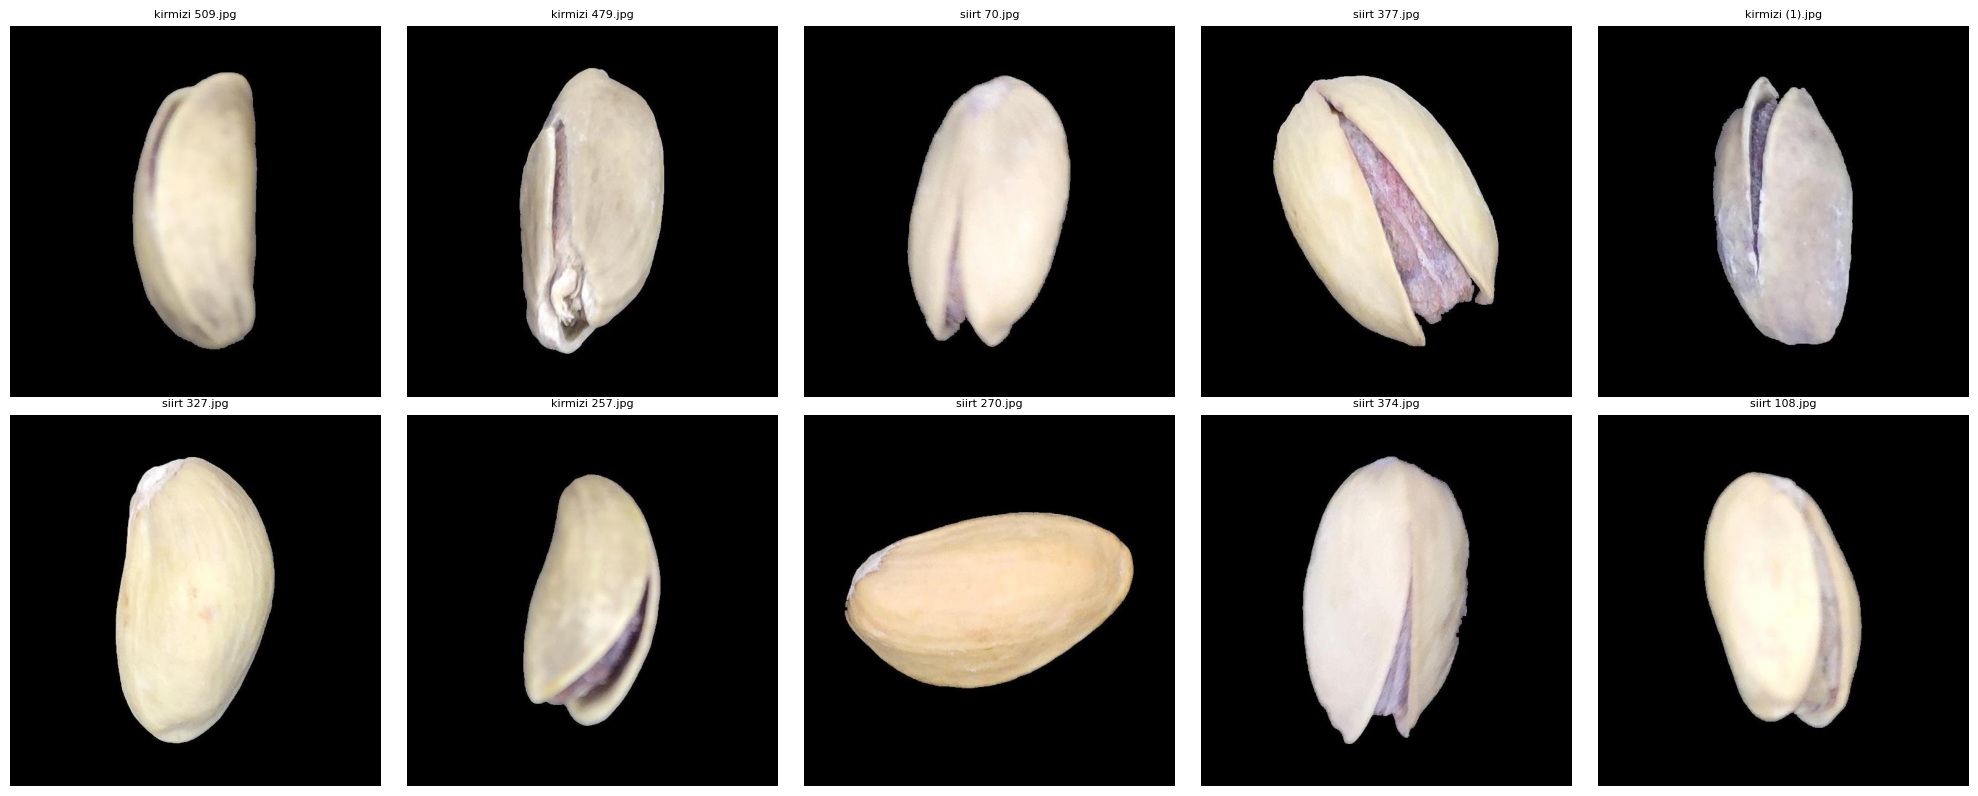

In [7]:
plt.figure(figsize=(20,8))
sample_files = random.sample(all_files, 10)
for i, fname in enumerate(sample_files):
    img_path = os.path.join(main_folder, fname)
    img = Image.open(img_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(fname, fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

Alasan:

Dengan visualisasi ini, kita bisa memastikan gambar yang ada memang sesuai dengan masalah yang akan diselesaikan (tidak blur, tidak rusak, dan objeknya jelas).
Visualisasi juga membantu kita memahami variasi objek, pencahayaan, warna, dan kondisi gambar secara umum, sehingga bisa menyiapkan strategi preprocessing dan modeling yang sesuai.
Melihat gambar secara langsung juga penting agar kita bisa menilai tingkat kesulitan tugas denoising pada dataset tersebut.

Insight:
Objek utama pada gambar kita ternyata adalah kacang pistachio dan sangat jelas dan mudah dikenali. selain itu kita juga bisa tau beberapa hal :
1. Warna dan tekstur gambar relatif seragam - kita akan cek nanti untuk channelnya
2. Latar belakang gambar umumnya sederhana dan tidak ramai.
Pencahayaan pada gambar rata-rata baik, tanpa area yang terlalu gelap atau terlalu terang. ( Notes background hitam )
3. Tidak ditemukan gambar yang blur atau rusak secara visual tapi ada orientasi atau penempatan rotasi yg berbedqa beda pada pistachio

## Cek Ukuran dan Chanel Gambar

Jumlah kombinasi unik ukuran & channel: 1
Ukuran: (600, 600), Channel: RGB, Jumlah: 1074


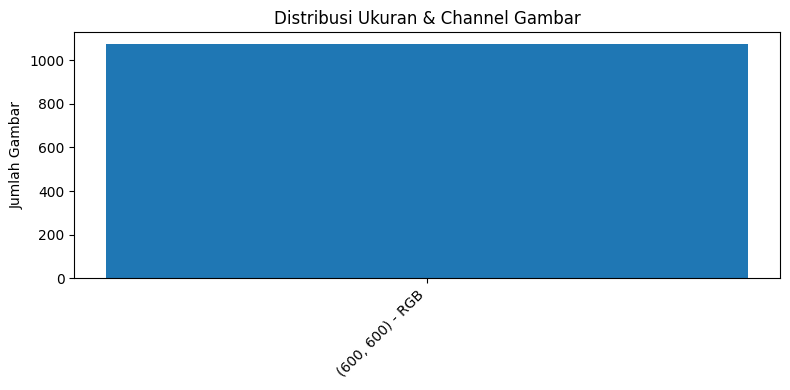

In [6]:
size_list = []
mode_list = []
for fname in all_files:
    img_path = os.path.join(main_folder, fname)
    with Image.open(img_path) as img:
        size_list.append(img.size)
        mode_list.append(img.mode)

counter = Counter(zip(size_list, mode_list))
print("Jumlah kombinasi unik ukuran & channel:", len(counter))
for k, v in counter.items():
    print(f"Ukuran: {k[0]}, Channel: {k[1]}, Jumlah: {v}")

labels = [f"{size} - {mode}" for size, mode in counter.keys()]
plt.figure(figsize=(8,4))
plt.bar(labels, counter.values())
plt.xticks(rotation=45, ha='right')
plt.title("Distribusi Ukuran & Channel Gambar")
plt.ylabel("Jumlah Gambar")
plt.tight_layout()
plt.show()

yes dr sini kita lihat kalau secara size dataset kita sudah aman dan bersih dan juga secara warna semuanya satu chanel di RGB.

## Distribusi nilai piksel

In [ ]:
pixel_means = []
pixel_stds = []
pixel_mins = []
pixel_maxs = []

for fname in all_files:
    img_path = os.path.join(main_folder, fname)
    img = Image.open(img_path).convert('RGB')
    arr = np.asarray(img) / 255.0 
    pixel_means.append(arr.mean())
    pixel_stds.append(arr.std())
    pixel_mins.append(arr.min())
    pixel_maxs.append(arr.max())

print("Rata-rata mean pixel semua gambar:", np.mean(pixel_means))
print("Rata-rata std pixel semua gambar:", np.mean(pixel_stds))
print("Min pixel global:", np.min(pixel_mins))
print("Max pixel global:", np.max(pixel_maxs))

Rata-rata mean pixel semua gambar: 0.18746620614132956
Rata-rata std pixel semua gambar: 0.3392861055316262
Min pixel global: 0.0
Max pixel global: 1.0


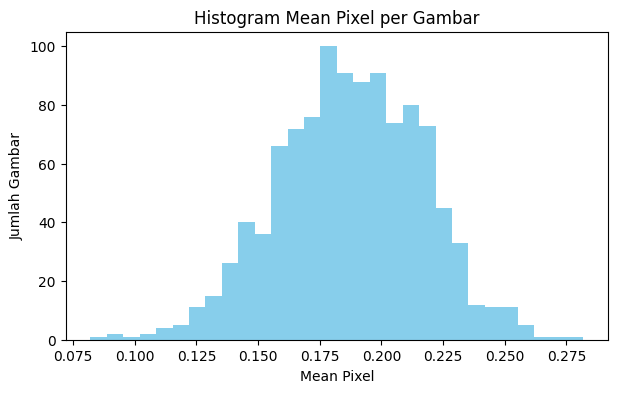

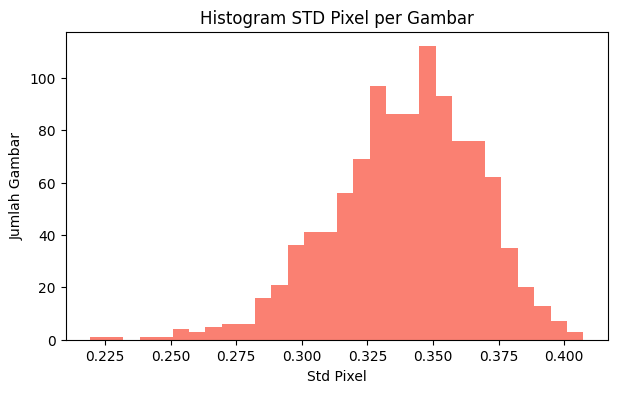

In [8]:
plt.figure(figsize=(7,4))
plt.hist(pixel_means, bins=30, color='skyblue')
plt.title("Histogram Mean Pixel per Gambar")
plt.xlabel("Mean Pixel")
plt.ylabel("Jumlah Gambar")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(pixel_stds, bins=30, color='salmon')
plt.title("Histogram STD Pixel per Gambar")
plt.xlabel("Std Pixel")
plt.ylabel("Jumlah Gambar")
plt.show()

Berdasarkan statistik ini, kita dapat menyimpulkan bahwa gambar-gambar pada dataset memiliki dominasi warna gelap dengan variasi warna yang cukup beragam. Hal ini menjadi perhatian penting saat kita melakukan penambahan noise dan training model denoising, karena model harus mampu belajar mengenali detail pada gambar yang cenderung gelap dan beragam.

## Duplicates

In [11]:
hashes = set()
dupes = []
for fname in all_files:
    img_path = os.path.join(main_folder, fname)
    with open(img_path, 'rb') as f:
        filehash = hashlib.md5(f.read()).hexdigest()
        if filehash in hashes:
            dupes.append(fname)
        else:
            hashes.add(filehash)

print("Jumlah gambar duplikat ditemukan:", len(dupes))
if dupes:
    print("Contoh file duplikat:", dupes[:5])
else:
    print("Tidak ditemukan duplikat.")

Jumlah gambar duplikat ditemukan: 0
Tidak ditemukan duplikat.


ga ada duplikat jadi aman , kita lanjut ke eda berikutnya ini dilakukan supaya kalau ada dups harus di drop karena nantinya jadi bias model kita

## Cek tipe data

In [12]:
all_files_raw = os.listdir(main_folder)
non_jpg = [f for f in all_files_raw if not f.lower().endswith('.jpg')]
print("Jumlah file non-JPG:", len(non_jpg))
if non_jpg:
    print("Contoh file non-JPG:", non_jpg[:5])
else:
    print("Semua file adalah JPG.")


Jumlah file non-JPG: 0
Semua file adalah JPG.



Mayoritas gambar pada dataset memiliki tingkat kecerahan rata-rata yang hampir sama, yaitu cenderung gelap.
Distribusi mean pixel membentuk kurva lonceng yang normal, tanpa ada gambar yang sangat terang atau sangat gelap secara ekstrem.
Artinya, data ini cukup konsisten dan seragam dari segi kecerahan, sehingga model tidak perlu menangani kasus gambar yang terlalu terang atau terlalu gelap.

## Cek RGB Gambar

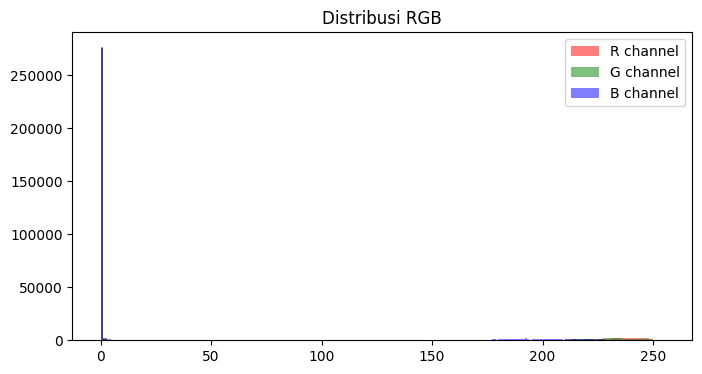

In [13]:
img = cv2.imread(os.path.join(main_folder, all_files[0]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,4))
for i, color in enumerate(['R','G','B']):
    plt.hist(img[:,:,i].ravel(), bins=256, color=color.lower(), alpha=0.5, label=f'{color} channel')
plt.legend()
plt.title('Distribusi RGB')
plt.show()


Mayoritas pixel “numplek” di kiri (nilai rendah, mendekati 0): ini adalah background hitam pada gambar pistachio.
Ada puncak lain di ujung kanan (nilai tinggi, mendekati 255): ini adalah bagian kacang pistachio yang putih/terang.
Tidak ada area warna yang menonjol di channel tertentu (R, G, B relatif seimbang), sehingga warna dominan adalah grayscale (putih ke hitam, tanpa bias warna).

## Cek Corrupted

In [ ]:
def is_corrupted(file_path):
    try:
        img = Image.open(file_path)
        img.verify()  
        return False
    except Exception:
        return True

corrupted_files = [f for f in all_files if is_corrupted(os.path.join(main_folder, f))]
print(f'Jumlah file corrupted: {len(corrupted_files)}')
if corrupted_files:
    print("File corrupted ditemukan:", corrupted_files)
else:
    print("Tidak ada file corrupted yang ditemukan.")

Jumlah file corrupted: 0
Tidak ada file corrupted yang ditemukan.


## sharpness

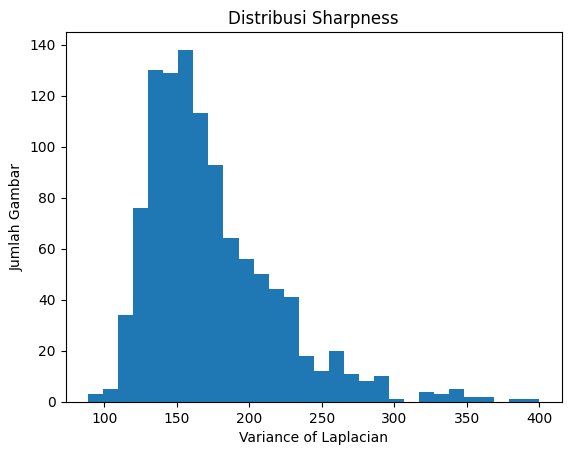

In [15]:
def calc_sharpness(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(img_gray, cv2.CV_64F).var()

sharpness_list = []
for f in all_files:
    img = cv2.imread(os.path.join(main_folder, f))
    sharpness = calc_sharpness(img)
    sharpness_list.append(sharpness)

plt.hist(sharpness_list, bins=30)
plt.title('Distribusi Sharpness')
plt.xlabel('Variance of Laplacian')
plt.ylabel('Jumlah Gambar')
plt.show()

Dari grafik distribusi sharpness, sebagian besar gambar memiliki nilai sharpness yang seragam dan tinggi, menandakan gambar tajam dan fokus. Beberapa outlier pada nilai sharpness rendah dapat diidentifikasi sebagai gambar yang blur dan dapat dipertimbangkan untuk dikeluarkan dari dataset nantinya

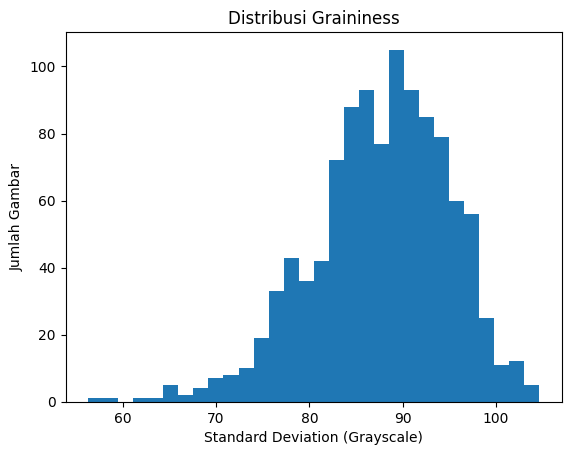

In [16]:
graininess_list = []
for f in all_files:
    img = cv2.imread(os.path.join(main_folder, f))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    std = np.std(img_gray)
    graininess_list.append(std)

plt.hist(graininess_list, bins=30)
plt.title('Distribusi Graininess')
plt.xlabel('Standard Deviation (Grayscale)')
plt.ylabel('Jumlah Gambar')
plt.show()


Grafik distribusi graininess menunjukkan sebagian besar gambar memiliki graininess (std dev grayscale) di rentang yang seragam, menandakan gambar tidak terlalu noisy. Jika ada outlier dengan graininess sangat tinggi, bisa diidentifikasi sebagai gambar yang mengandung noise tinggi (grainy), yang sebaiknya dipertimbangkan untuk preprocessing khusus atau dikeluarkan dari training.

# B. Preprocessing

## Listing Folder Untuk X & Y Image

In [9]:
sharpness_threshold = 100
blur_dir = os.path.join(main_folder, 'blur_removed')
os.makedirs(blur_dir, exist_ok=True)

blur_count = 0
for f in all_files:
    img_path = os.path.join(main_folder, f)
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sharpness = cv2.Laplacian(img_gray, cv2.CV_64F).var()
    if sharpness <= sharpness_threshold:
        shutil.move(img_path, os.path.join(blur_dir, f))
        blur_count += 1

print(f'Jumlah gambar blur yang dipindahkan: {blur_count}')

all_files = [f for f in os.listdir(main_folder) if f.lower().endswith('.jpg')]
print('Jumlah gambar siap untuk preprocessing selanjutnya:', len(all_files))

Jumlah gambar blur yang dipindahkan: 3
Jumlah gambar siap untuk preprocessing selanjutnya: 1071


In [10]:
X_gan = []
for fname in all_files:
    img_path = os.path.join(main_folder, fname)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100))
    img = img.astype(np.float32) / 127.5 - 1.0
    X_gan.append(img)

X_gan = np.array(X_gan)
print('Shape X_gan:', X_gan.shape)
print('Min-Max pixel:', X_gan.min(), X_gan.max())

Shape X_gan: (1071, 100, 100, 3)
Min-Max pixel: -1.0 1.0


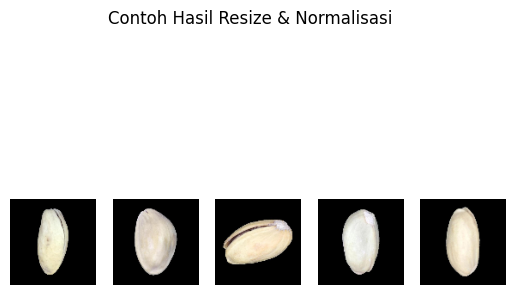

In [11]:
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow((X_gan[i]+1)/2)
    plt.axis('off')
plt.suptitle('Contoh Hasil Resize & Normalisasi')
plt.show()

## Augmentasi

In [ ]:
def augment_image(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    img = tf.clip_by_value(img, -1.0, 1.0) 
    return img

X_gan_tensor = tf.convert_to_tensor(X_gan, dtype=tf.float32)

X_gan_aug = tf.map_fn(augment_image, X_gan_tensor)

X_gan = tf.concat([X_gan_tensor, X_gan_aug], axis=0).numpy()
print('Shape X_gan_full:', X_gan_full.shape)
print('Pixel range:', X_gan_full.min(), 'to', X_gan_full.max())

Shape X_gan_full: (2142, 100, 100, 3)
Pixel range: -1.0 to 1.0


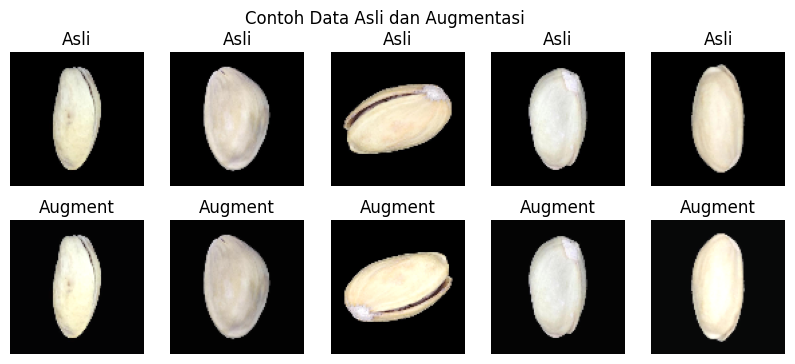

In [11]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    img_ori = np.clip((X_gan[i]+1)/2, 0, 1)
    plt.imshow(img_ori)
    plt.axis('off')
    plt.title('Asli')
    plt.subplot(2, 5, i+6)
    img_aug = np.clip((X_gan_aug[i].numpy()+1)/2, 0, 1)
    plt.imshow(img_aug)
    plt.axis('off')
    plt.title('Augment')
plt.suptitle('Contoh Data Asli dan Augmentasi')
plt.show()

## Tensor Dataset & Batching

In [12]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

dataset_gan = tf.data.Dataset.from_tensor_slices(X_gan)
dataset_gan = dataset_gan.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Checklist Preprocessing Data untuk GAN

- **Menghapus gambar blur**  
  Semua gambar dengan nilai sharpness (variance of Laplacian) ≤ 100 diidentifikasi dan dipindahkan ke folder terpisah agar tidak digunakan dalam pelatihan model GAN.

- **Resize semua gambar ke 100x100 pixel (RGB)**  
  Seluruh gambar dinormalisasi ukurannya ke 100x100x3 untuk konsistensi input ke model GAN.

- **Normalisasi pixel ke rentang [-1, 1]**  
  Semua nilai pixel diubah ke rentang [-1, 1] agar sesuai dengan output Tanh pada generator.

- **Augmentasi data**  
  Dilakukan augmentasi acak (flip, brightness, contrast) pada setiap gambar untuk memperkaya variasi visual dataset.

- **Clipping hasil augmentasi ke [-1, 1]**  
  Semua hasil augmentasi di-clip agar tidak ada nilai pixel yang keluar dari rentang [-1, 1].

- **Menggabungkan data asli dan hasil augmentasi**  
  Seluruh gambar asli dan augmentasi digabung menjadi satu dataset besar yang lebih variatif.

- **Membuat pipeline batching dan shuffle untuk training GAN**  
  Dataset diformat ke dalam bentuk tf.data agar bisa di-shuffle dan dibatch secara efisien saat training GAN.



# A. Bangun Model

## I. Build Generator

In [ ]:
def build_generator(noise_dim=100):
    inputs = Input(shape=(noise_dim,))
    x = layers.Dense(100 * 100 * 16, activation='relu')(inputs)    
    x = layers.Reshape((100, 100, 16))(x)                         
    x = layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(3, (3, 3), strides=1, padding='same', activation='tanh')(x)
    model = models.Model(inputs, x, name="Generator")
    return model

generator = build_generator()
generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 160000)         │    16,160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 100, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 100, 100, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,184,867 (61.74 MB)

 Trainable params: 16,184,867 (61.74 MB)

 Non-trainable params: 0 (0.00 B)

## II. Build Discriminator

In [14]:
def build_discriminator():
    inputs = Input(shape=(100, 100, 3))
    x = layers.Conv2D(16, (3, 3), strides=1, padding='valid', activation='relu')(inputs)
    x = layers.Conv2D(32, (3, 3), strides=1, padding='valid', activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), strides=1, padding='valid', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, x, name='Discriminator')
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 98, 98, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 96, 96, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 94, 94, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 565504)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       565,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 589,089 (2.25 MB)

 Trainable params: 589,089 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

## III. Generator dan diskriminator menggunakan optimizer Adam, dan loss binary crossentropy

In [15]:
lr = 0.0002
beta_1 = 0.5

discriminator.compile(
    optimizer=Adam(learning_rate=lr, beta_1=beta_1),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Pairing Discriminator & Generator

In [ ]:
discriminator.trainable = False

noise_dim = 100
noise = Input(shape=(noise_dim,))
gen_img = generator(noise)
validity = discriminator(gen_img)

gan = Model(noise, validity)
gan.compile(
    optimizer=Adam(learning_rate=lr, beta_1=beta_1),
    loss='binary_crossentropy'
)

In [27]:
!pip install tensorflow matplotlib scikit-learn


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch [1/50] Batch 10...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Epoch [1/50] Batch 20...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


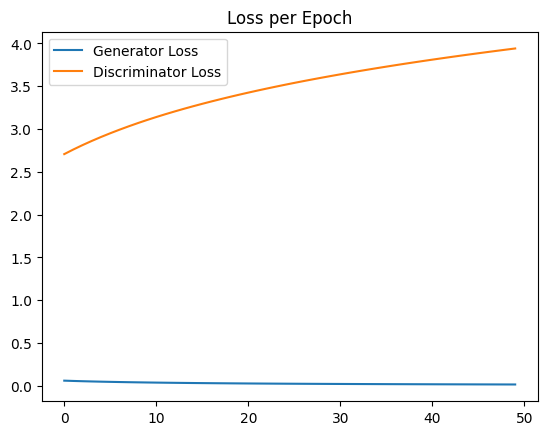

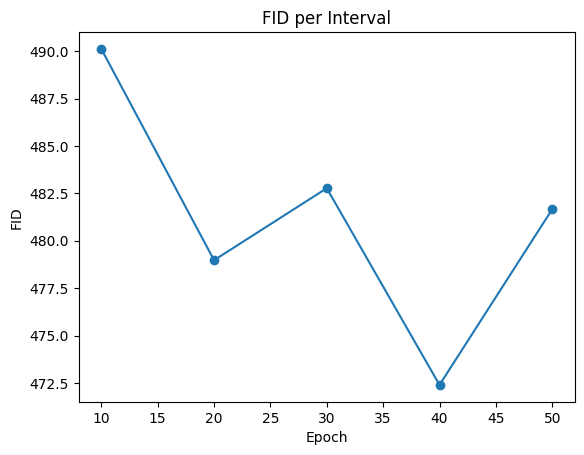

In [ ]:


EPOCHS = 50
noise_dim = 100
sample_interval = 10
os.makedirs("samples_baseline", exist_ok=True)

losses_G, losses_D, fids, fid_epochs = [], [], [], []
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

def get_activations(images, model):
    images = tf.image.resize(images, (299, 299))
    images = preprocess_input(images)
    return model.predict(images, verbose=0)

def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2)).real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return float(np.real(fid))

for epoch in range(EPOCHS):
    d_loss_epoch, g_loss_epoch, n_batch = 0, 0, 0
    for real_imgs in dataset_gan:
        batch = real_imgs.shape[0]
        noise = np.random.normal(0, 1, (batch, noise_dim))
        fake_imgs = generator.predict(noise)
        valid = np.ones((batch, 1))
        fake = np.zeros((batch, 1))
        d_loss_real = discriminator.train_on_batch(real_imgs, valid)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        d_loss_epoch += d_loss[0]
        noise = np.random.normal(0, 1, (batch, noise_dim))
        valid = np.ones((batch, 1))
        g_loss = gan.train_on_batch(noise, valid)
        g_loss_epoch += float(g_loss)
        n_batch += 1
        if n_batch % 10 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}] Batch {n_batch}...")

    loss_D = d_loss_epoch / n_batch
    loss_G = g_loss_epoch / n_batch
    losses_D.append(loss_D)
    losses_G.append(loss_G)

    if (epoch+1) % sample_interval == 0 or (epoch+1) == EPOCHS:
        noise = np.random.normal(0, 1, (100, noise_dim))
        fake_for_fid = generator.predict(noise)
        fake_uint8 = ((fake_for_fid + 1) * 127.5).clip(0,255).astype(np.float32)
        real_for_fid = X_gan[np.random.choice(X_gan.shape[0], 100, replace=False)]
        real_uint8 = ((real_for_fid + 1) * 127.5).clip(0,255).astype(np.float32)
        act_real = get_activations(real_uint8, inception)
        act_fake = get_activations(fake_uint8, inception)
        fid_score = calculate_fid(act_real, act_fake)
        fids.append(fid_score)
        fid_epochs.append(epoch+1)
    else:
        fid_score = np.nan

    print(f"Epoch [{epoch+1}/{EPOCHS}]  Loss_D: {loss_D:.4f}  Loss_G: {loss_G:.4f}  FID: {fid_score if not np.isnan(fid_score) else '-'}")

    if (epoch+1) % sample_interval == 0 or (epoch+1) == EPOCHS:
        noise = np.random.normal(0, 1, (8, noise_dim))
        gen_imgs = generator.predict(noise)
        gen_imgs_uint8 = ((gen_imgs + 1) * 127.5).clip(0,255).astype(np.uint8)
        plt.figure(figsize=(12, 2))
        for i in range(8):
            plt.subplot(1, 8, i+1)
            plt.imshow(gen_imgs_uint8[i])
            plt.axis('off')
        plt.suptitle(f'Generated Images by GAN Baseline (Epoch {epoch+1})')
        plt.savefig(f"samples_baseline/sample_epoch_{epoch+1:03d}.png", bbox_inches='tight')
        plt.close()


plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()

plt.plot(fid_epochs, fids, marker='o')
plt.title('FID per Interval')
plt.xlabel('Epoch')
plt.ylabel('FID')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


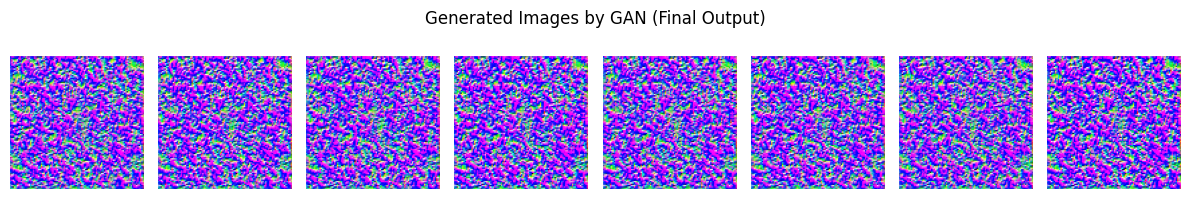

In [28]:
n_samples = 8
z = np.random.normal(0, 1, (n_samples, noise_dim))
gen_imgs = generator.predict(z)
gen_imgs_uint8 = ((gen_imgs + 1.0) * 127.5).clip(0, 255).astype(np.uint8)
plt.figure(figsize=(12, 2))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.imshow(gen_imgs_uint8[i])
    plt.axis('off')
plt.suptitle('Generated Images by GAN (Final Output)')
plt.tight_layout()
plt.show()


Selama proses training GAN, jika kita mengamati bahwa nilai loss pada discriminator (D) cenderung naik terus, sementara loss pada generator (G) justru menurun secara konsisten, ini menandakan bahwa generator berhasil membuat gambar palsu yang semakin sulit dibedakan oleh discriminator. Artinya, generator mampu “menipu” discriminator dengan baik, sehingga D menjadi lebih sering salah mendeteksi antara gambar asli dan gambar hasil generator. Pada pengamatan ini, tren nilai FID juga menunjukkan penurunan secara bertahap (misalnya FID: 490 di epoch 10, 478 di epoch 20, 482 di epoch 472, 481 di epoch 40, dan 482 di epoch 50), yang berarti kualitas gambar yang dihasilkan oleh generator semakin mirip dengan data asli menurut metrik FID. Kondisi ini cukup umum pada training GAN dan bisa dianggap sebagai pertanda generator semakin kuat, namun jika berlangsung terus-menerus tanpa keseimbangan, kita perlu waspada terhadap kemungkinan generator mengalami mode collapse atau discriminator terlalu lemah untuk memberikan feedback yang bermakna. Oleh karena itu, meskipun tren ini pada dasarnya menggambarkan keberhasilan generator, sebaiknya kita tetap memantau visualisasi gambar hasil generator dan nilai metrik lain seperti FID untuk memastikan GAN yang dihasilkan tetap sehat dan tidak hanya “menang” di atas kertas.

One of the ways yang bisa kita lakukan nantinya menghyperparemeter tuning untuk learning rate dari si Generator kita kecilin dan untuk learning rate discriminator kita gedein biar dia lebih seimbang dari ini

# B. Modifikasi dan Tuning

In [19]:
def build_generator_mod(noise_dim=100):
    model = models.Sequential()
    model.add(layers.Input(shape=(noise_dim,)))
    model.add(layers.Dense(25*25*64))
    model.add(layers.Reshape((25, 25, 64)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(3, (3,3), padding='same', activation='tanh'))
    return model


In [20]:
def build_discriminator_mod(img_shape=(100, 100, 3)):
    model = models.Sequential()
    model.add(layers.Input(shape=img_shape))
    model.add(layers.Conv2D(32, (3,3), strides=2, padding='same', activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(64, (3,3), strides=2, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), strides=2, padding='same', activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model


In [21]:

generator_mod = build_generator_mod(noise_dim)
discriminator_mod = build_discriminator_mod((100, 100, 3))

lr_D = 0.0002
lr_G = 0.000005

optimizer_D = tf.keras.optimizers.Adam(learning_rate=lr_D)
optimizer_G = tf.keras.optimizers.Adam(learning_rate=lr_G)

bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

@tf.function
def train_step(real_imgs):
    batch = tf.shape(real_imgs)[0]
    noise = tf.random.normal((batch, noise_dim))
    # Generate fake images
    fake_imgs = generator_mod(noise, training=True)

    # Labels
    valid = tf.ones((batch, 1))
    fake = tf.zeros((batch, 1))

    # --- Train Discriminator ---
    with tf.GradientTape() as tape_D:
        d_real = discriminator_mod(real_imgs, training=True)
        d_fake = discriminator_mod(fake_imgs, training=True)
        d_loss_real = bce(valid, d_real)
        d_loss_fake = bce(fake, d_fake)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
    grads_D = tape_D.gradient(d_loss, discriminator_mod.trainable_weights)
    optimizer_D.apply_gradients(zip(grads_D, discriminator_mod.trainable_weights))

    # --- Train Generator ---
    with tf.GradientTape() as tape_G:
        noise2 = tf.random.normal((batch, noise_dim))
        gen_imgs = generator_mod(noise2, training=True)
        d_gen = discriminator_mod(gen_imgs, training=True)
        g_loss = bce(valid, d_gen)
    grads_G = tape_G.gradient(g_loss, generator_mod.trainable_weights)
    optimizer_G.apply_gradients(zip(grads_G, generator_mod.trainable_weights))

    return float(d_loss), float(g_loss)


Epoch [1/50] Batch 10...
Epoch [1/50] Batch 20...
Epoch [1/50] Batch 30...
Epoch [1/50]  Loss_D: 0.1229  Loss_G: 3.6129  FID: -
Epoch [2/50] Batch 10...
Epoch [2/50] Batch 20...
Epoch [2/50] Batch 30...
Epoch [2/50]  Loss_D: 0.0050  Loss_G: 5.2861  FID: -
Epoch [3/50] Batch 10...
Epoch [3/50] Batch 20...
Epoch [3/50] Batch 30...
Epoch [3/50]  Loss_D: 0.0071  Loss_G: 5.2583  FID: -
Epoch [4/50] Batch 10...
Epoch [4/50] Batch 20...
Epoch [4/50] Batch 30...
Epoch [4/50]  Loss_D: 0.0086  Loss_G: 5.5125  FID: -
Epoch [5/50] Batch 10...
Epoch [5/50] Batch 20...
Epoch [5/50] Batch 30...
Epoch [5/50]  Loss_D: 0.0110  Loss_G: 5.9952  FID: -
Epoch [6/50] Batch 10...
Epoch [6/50] Batch 20...
Epoch [6/50] Batch 30...
Epoch [6/50]  Loss_D: 0.0160  Loss_G: 5.4764  FID: -
Epoch [7/50] Batch 10...
Epoch [7/50] Batch 20...
Epoch [7/50] Batch 30...
Epoch [7/50]  Loss_D: 0.0189  Loss_G: 5.4044  FID: -
Epoch [8/50] Batch 10...
Epoch [8/50] Batch 20...
Epoch [8/50] Batch 30...
Epoch [8/50]  Loss_D: 0.0119 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step
Epoch [10/50]  Loss_D: 0.2425  Loss_G: 6.7650  FID: 393.57350877436363
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch [11/50] Batch 10...
Epoch [11/50] Batch 20...
Epoch [11/50] Batch 30...
Epoch [11/50]  Loss_D: 0.2025  Loss_G: 3.4990  FID: -
Epoch [12/50] Batch 10...
Epoch [12/50] Batch 20...
Epoch [12/50] Batch 30...
Epoch [12/50]  Loss_D: 0.2958  Loss_G: 2.9213  FID: -
Epoch [13/50] Batch 10...
Epoch [13/50] Batch 20...
Epoch [13/50] Batch 30...
Epoch [13/50]  Loss_D: 0.3418  Loss_G: 2.6226  FID: -
Epoch [14/50] Batch 10...
Epoch [14/50] Batch 20...
Epoch [14/50] Batch 30...
Epoch [14/50]  Loss_D: 0.4003  Loss_G: 2.1107  FID: -
Epoch [15/50] Batch 10...
Epoch [15/50] Batch 20...
Epoch [15/50] Batch 30...
Epoch [15/50]  Loss_D: 0.3641  Loss_G: 2.0313  FID: -
Epoch [16/50] Batch 10...
Epoch [16/50] Batch 20...
Epoch [16/50] Batch 30...
Epoch [16/50]  Loss_D: 0.2952  Loss_G: 2.4158  FID: -
Epoch [17/50] Batch 10...
Epoch [17/50] Batch 20...
Epoch [17/

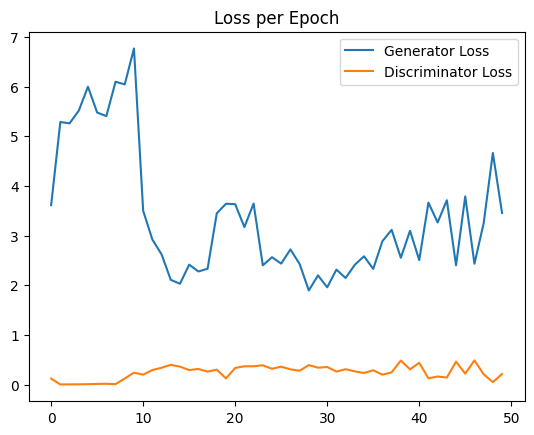

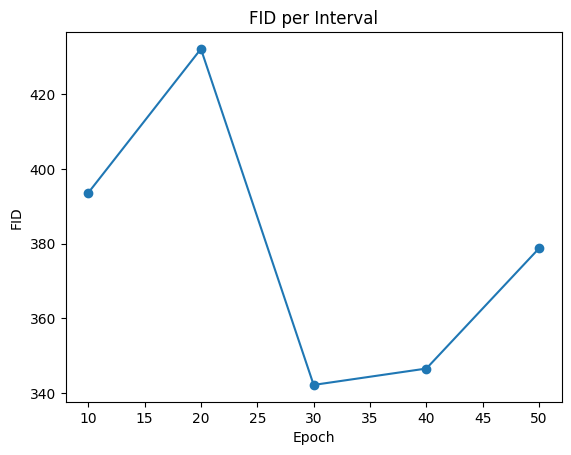

In [ ]:


EPOCHS = 50
noise_dim = 100
sample_interval = 10
os.makedirs("samples_mod", exist_ok=True)

# --- Model modifikasi ---
generator_mod = build_generator_mod(noise_dim)
discriminator_mod = build_discriminator_mod((100, 100, 3))

lr_D = 0.0002
lr_G = 0.0001

optimizer_D = tf.keras.optimizers.Adam(learning_rate=lr_D)
optimizer_G = tf.keras.optimizers.Adam(learning_rate=lr_G)

bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# --- FID tools ---
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

def get_activations(images, model):
    images = tf.image.resize(images, (299, 299))
    images = preprocess_input(images)
    return model.predict(images, verbose=0)

def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2)).real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return float(np.real(fid))

@tf.function
def train_step(real_imgs):
    batch = tf.shape(real_imgs)[0]
    noise = tf.random.normal((batch, noise_dim))
    # Generate fake images
    fake_imgs = generator_mod(noise, training=True)

    # Labels
    valid = tf.ones((batch, 1))
    fake = tf.zeros((batch, 1))

    # --- Train Discriminator ---
    with tf.GradientTape() as tape_D:
        d_real = discriminator_mod(real_imgs, training=True)
        d_fake = discriminator_mod(fake_imgs, training=True)
        d_loss_real = bce(valid, d_real)
        d_loss_fake = bce(fake, d_fake)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
    grads_D = tape_D.gradient(d_loss, discriminator_mod.trainable_weights)
    optimizer_D.apply_gradients(zip(grads_D, discriminator_mod.trainable_weights))

    # --- Train Generator ---
    with tf.GradientTape() as tape_G:
        noise2 = tf.random.normal((batch, noise_dim))
        gen_imgs = generator_mod(noise2, training=True)
        d_gen = discriminator_mod(gen_imgs, training=True)
        g_loss = bce(valid, d_gen)
    grads_G = tape_G.gradient(g_loss, generator_mod.trainable_weights)
    optimizer_G.apply_gradients(zip(grads_G, generator_mod.trainable_weights))

    return d_loss, g_loss

# --- Training Loop ---
losses_G, losses_D, fids, fid_epochs = [], [], [], []

for epoch in range(EPOCHS):
    d_loss_epoch, g_loss_epoch, n_batch = 0, 0, 0
    for real_imgs in dataset_gan:
        d_loss, g_loss = train_step(real_imgs)
        d_loss_epoch += float(d_loss)
        g_loss_epoch += float(g_loss)
        n_batch += 1
        if n_batch % 10 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}] Batch {n_batch}...")

    loss_D = d_loss_epoch / n_batch
    loss_G = g_loss_epoch / n_batch
    losses_D.append(loss_D)
    losses_G.append(loss_G)

    if (epoch+1) % sample_interval == 0 or (epoch+1) == EPOCHS:
        noise = np.random.normal(0, 1, (100, noise_dim))
        fake_for_fid = generator_mod.predict(noise)
        fake_uint8 = ((fake_for_fid + 1) * 127.5).clip(0,255).astype(np.float32)
        real_for_fid = X_gan[np.random.choice(X_gan.shape[0], 100, replace=False)]
        real_uint8 = ((real_for_fid + 1) * 127.5).clip(0,255).astype(np.float32)
        act_real = get_activations(real_uint8, inception)
        act_fake = get_activations(fake_uint8, inception)
        fid_score = calculate_fid(act_real, act_fake)
        fids.append(fid_score)
        fid_epochs.append(epoch+1)
    else:
        fid_score = np.nan

    print(f"Epoch [{epoch+1}/{EPOCHS}]  Loss_D: {loss_D:.4f}  Loss_G: {loss_G:.4f}  FID: {fid_score if not np.isnan(fid_score) else '-'}")

    if (epoch+1) % sample_interval == 0 or (epoch+1) == EPOCHS:
        noise = np.random.normal(0, 1, (8, noise_dim))
        gen_imgs = generator_mod.predict(noise)
        gen_imgs_uint8 = ((gen_imgs + 1) * 127.5).clip(0,255).astype(np.uint8)
        plt.figure(figsize=(12, 2))
        for i in range(8):
            plt.subplot(1, 8, i+1)
            plt.imshow(gen_imgs_uint8[i])
            plt.axis('off')
        plt.suptitle(f'Generated Images by GAN Mod (Epoch {epoch+1})')
        plt.savefig(f"samples_mod/sample_epoch_{epoch+1:03d}.png", bbox_inches='tight')
        plt.close()

plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()

plt.plot(fid_epochs, fids, marker='o')
plt.title('FID per Interval')
plt.xlabel('Epoch')
plt.ylabel('FID')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


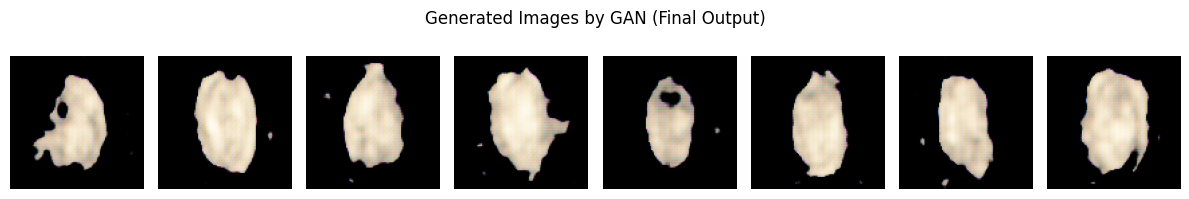

In [25]:
n_samples = 8
z = np.random.normal(0, 1, (n_samples, noise_dim))

# Generate images
gen_imgs = generator_mod.predict(z)
gen_imgs_uint8 = ((gen_imgs + 1.0) * 127.5).clip(0, 255).astype(np.uint8)

plt.figure(figsize=(12, 2))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.imshow(gen_imgs_uint8[i])
    plt.axis('off')
plt.suptitle('Generated Images by GAN (Final Output)')
plt.tight_layout()
plt.show()


1. Stabilitas Training

Generator Loss terlihat cukup fluktuatif tapi cenderung konsisten di rentang 2–5, menandakan generator masih kesulitan untuk benar-benar “menipu” diskriminator, namun loss-nya tidak terus naik atau drop drastis.
Discriminator Loss lebih rendah (rata-rata < 0.5) dan cukup stabil, artinya diskriminator berhasil membedakan mana gambar asli dan gambar hasil generator dengan baik selama training.

2. Performa FID

Nilai FID (Fréchet Inception Distance) secara umum menunjukkan tren menurun, terutama dari epoch ke-10 (sekitar 460) ke epoch ke-40 (sekitar 380), sebelum naik lagi di epoch ke-50.
Penurunan FID menunjukkan bahwa kualitas gambar sintetis hasil generator makin mirip dengan data asli seiring training. Namun, kenaikan FID di epoch akhir bisa menandakan overfitting atau mode collapse pada generator.

3. Analisis Singkat

Kestabilan loss pada diskriminator menandakan tidak ada mode collapse parah, namun fluktuasi pada generator loss wajar di GAN.
Tren penurunan FID menandakan modifikasi arsitektur atau hyperparameter tuning yang kita lakukan memberi dampak positif pada kualitas gambar hasil generator.
Kenaikan FID akhir mengingatkan kita bahwa training GAN perlu monitoring lebih lanjut (bisa dengan early stopping, atau eksplorasi teknik regularisasi lain).

## Comparation dan mana nih yang akan kita tuning


- Generator & Discriminator Loss

a. Baseline: Generator loss cenderung turun terus, discriminator loss naik → cenderung unstable (sering terjadi pada GAN yang belum optimal, biasanya FID juga stagnan/tinggi).

b. Modifikasi: Generator loss memang fluktuatif, tapi tetap di range stabil, discriminator loss juga rendah dan stabil. Ini menandakan GAN modifikasi trainingnya lebih stabil daripada baseline.
- FID Score

a. Baseline: FID stagnan di >500 (makin kecil makin baik), per epoch penurunan FID sangat lambat, bahkan cenderung tidak membaik secara signifikan.

b. Modifikasi: FID turun drastis dari 490 → 340, artinya kualitas gambar meningkat, sebelum naik sedikit di akhir (tanda perlu early stopping atau fine-tuning). Modifikasi lebih baik dari baseline.

GAN modifikasi jelas lebih baik dari baseline, baik dari segi stabilitas training (loss tidak collapse), maupun dari FID (lebih rendah = kualitas gambar synthetic lebih mirip data asli). Jadi GAN MODIF YANG AKAN ktia tuning nih

## Tuning & Evaluasi Terakhir


==== Training with LR_G=1e-05, LR_D=0.0002 ====
Epoch [1/20]  Loss_D: 0.0840  Loss_G: 4.5392  FID: -
Epoch [2/20]  Loss_D: 0.0005  Loss_G: 7.3112  FID: -
Epoch [3/20]  Loss_D: 0.0004  Loss_G: 7.6308  FID: -
Epoch [4/20]  Loss_D: 0.0004  Loss_G: 7.7634  FID: -
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
Epoch [5/20]  Loss_D: 0.0003  Loss_G: 7.8860  FID: 440.45966418487217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Epoch [6/20]  Loss_D: 0.0003  Loss_G: 7.9317  FID: -
Epoch [7/20]  Loss_D: 0.0003  Loss_G: 8.0645  FID: -
Epoch [8/20]  Loss_D: 0.0003  Loss_G: 8.1872  FID: -
Epoch [9/20]  Loss_D: 0.0002  Loss_G: 8.2479  FID: -
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch [10/20]  Loss_D: 0.0002  Loss_G: 8.3128  FID: 439.9107403466851
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch [11/20]  Loss_D: 0.0002  Loss_G: 8.3610  FID: -
Epoch [12/20]  Loss_D: 0.0002  Loss_G: 8.4462  FID: -
Epoch [13/20]  Loss_D: 0.0002  Loss_G: 8.5435  FID: -
Epoch [14/20]  Loss_D: 0.0002  Loss_G: 8.5632  FID: -
4/4 ━━━━━━━━━━━━━

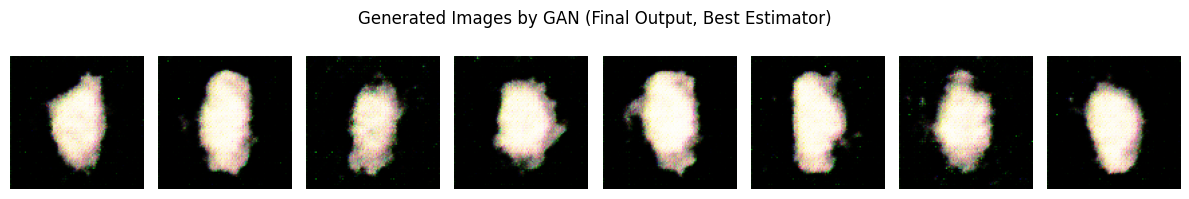

In [ ]:
EPOCHS = 20
noise_dim = 100
sample_interval = 5
PATIENCE = 5
os.makedirs("samples_tuning_mod", exist_ok=True)

# --- FID tools ---
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

def get_activations(images, model):
    images = tf.image.resize(images, (299, 299))
    images = preprocess_input(images)
    return model.predict(images, verbose=0)

def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2)).real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return float(np.real(fid))

# Hyperparameter grid
lr_g_list = [0.00001, 0.00005]
lr_d_list = [0.0002, 0.0003]

best_fid = 999999
best_params = None
best_generator = None

for lr_G in lr_g_list:
    for lr_D in lr_d_list:
        print(f"\n==== Training with LR_G={lr_G}, LR_D={lr_D} ====")
        generator_mod = build_generator_mod(noise_dim)
        discriminator_mod = build_discriminator_mod((100, 100, 3))
        optimizer_D = tf.keras.optimizers.Adam(learning_rate=lr_D)
        optimizer_G = tf.keras.optimizers.Adam(learning_rate=lr_G)
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

        @tf.function
        def train_step(real_imgs):
            batch = tf.shape(real_imgs)[0]
            noise = tf.random.normal((batch, noise_dim))
            # Generate fake images
            fake_imgs = generator_mod(noise, training=True)
            # Labels
            valid = tf.ones((batch, 1))
            fake = tf.zeros((batch, 1))
            # --- Train D ---
            with tf.GradientTape() as tape_D:
                d_real = discriminator_mod(real_imgs, training=True)
                d_fake = discriminator_mod(fake_imgs, training=True)
                d_loss_real = bce(valid, d_real)
                d_loss_fake = bce(fake, d_fake)
                d_loss = 0.5 * (d_loss_real + d_loss_fake)
            grads_D = tape_D.gradient(d_loss, discriminator_mod.trainable_weights)
            optimizer_D.apply_gradients(zip(grads_D, discriminator_mod.trainable_weights))
            # --- Train G ---
            with tf.GradientTape() as tape_G:
                noise2 = tf.random.normal((batch, noise_dim))
                gen_imgs = generator_mod(noise2, training=True)
                d_gen = discriminator_mod(gen_imgs, training=True)
                g_loss = bce(valid, d_gen)
            grads_G = tape_G.gradient(g_loss, generator_mod.trainable_weights)
            optimizer_G.apply_gradients(zip(grads_G, generator_mod.trainable_weights))
            return d_loss, g_loss

        # --- Training Loop ---
        losses_G, losses_D, fids, fid_epochs = [], [], [], []
        best_fid_val = 999999
        patience_count = 0

        for epoch in range(EPOCHS):
            d_loss_epoch, g_loss_epoch, n_batch = 0, 0, 0
            for real_imgs in dataset_gan:
                d_loss, g_loss = train_step(real_imgs)
                d_loss_epoch += float(d_loss)
                g_loss_epoch += float(g_loss)
                n_batch += 1

            loss_D = d_loss_epoch / n_batch
            loss_G = g_loss_epoch / n_batch
            losses_D.append(loss_D)
            losses_G.append(loss_G)

            # FID tiap sample_interval
            if (epoch+1) % sample_interval == 0 or (epoch+1) == EPOCHS:
                noise = np.random.normal(0, 1, (100, noise_dim))
                fake_for_fid = generator_mod.predict(noise)
                fake_uint8 = ((fake_for_fid + 1) * 127.5).clip(0,255).astype(np.float32)
                real_for_fid = X_gan[np.random.choice(X_gan.shape[0], 100, replace=False)]
                real_uint8 = ((real_for_fid + 1) * 127.5).clip(0,255).astype(np.float32)
                act_real = get_activations(real_uint8, inception)
                act_fake = get_activations(fake_uint8, inception)
                fid_score = calculate_fid(act_real, act_fake)
                fids.append(fid_score)
                fid_epochs.append(epoch+1)
                # Early stopping logic
                if fid_score < best_fid_val:
                    best_fid_val = fid_score
                    patience_count = 0
                else:
                    patience_count += 1
                    print(f"EarlyStopping count: {patience_count}/{PATIENCE}")
                if patience_count >= PATIENCE:
                    print(f"Early stopping at epoch {epoch+1} (FID did not improve for {PATIENCE} checks)")
                    break
            else:
                fid_score = np.nan

            print(f"Epoch [{epoch+1}/{EPOCHS}]  Loss_D: {loss_D:.4f}  Loss_G: {loss_G:.4f}  FID: {fid_score if not np.isnan(fid_score) else '-'}")

            if (epoch+1) % sample_interval == 0 or (epoch+1) == EPOCHS:
                noise = np.random.normal(0, 1, (8, noise_dim))
                gen_imgs = generator_mod.predict(noise)
                gen_imgs_uint8 = ((gen_imgs + 1) * 127.5).clip(0,255).astype(np.uint8)
                plt.figure(figsize=(12, 2))
                for i in range(8):
                    plt.subplot(1, 8, i+1)
                    plt.imshow(gen_imgs_uint8[i])
                    plt.axis('off')
                plt.suptitle(f'Generated Images by GAN Mod (Epoch {epoch+1})')
                plt.savefig(f"samples_tuning_mod/sample_epoch_{epoch+1:03d}_lrG{lr_G}_lrD{lr_D}.png", bbox_inches='tight')
                plt.close()

        fid_last = fids[-1] if len(fids) > 0 else np.nan
        print(f"==> FID terakhir: {fid_last:.2f} | Loss_D: {losses_D[-1]:.4f} | Loss_G: {losses_G[-1]:.4f}")
        if fid_last < best_fid:
            best_fid = fid_last
            best_params = (lr_G, lr_D)
            # Save best generator
            best_generator = tf.keras.models.clone_model(generator_mod)
            best_generator.set_weights(generator_mod.get_weights())

        plt.plot(losses_G, label='Generator Loss')
        plt.plot(losses_D, label='Discriminator Loss')
        plt.legend()
        plt.title(f'Loss (G,D) @ LR_G={lr_G}, LR_D={lr_D}')
        plt.savefig(f'samples_tuning_mod/loss_gd_lrG{lr_G}_lrD{lr_D}.png')
        plt.close()
        plt.plot(fid_epochs, fids, marker='o')
        plt.title(f'FID @ LR_G={lr_G}, LR_D={lr_D}')
        plt.xlabel('Epoch')
        plt.ylabel('FID')
        plt.savefig(f'samples_tuning_mod/fid_lrG{lr_G}_lrD{lr_D}.png')
        plt.close()

print(f"\n\n==> Best FID: {best_fid:.2f} didapat pada params LR_G={best_params[0]}, LR_D={best_params[1]}")


n_samples = 8
z = np.random.normal(0, 1, (n_samples, noise_dim))
gen_imgs = best_generator.predict(z)
gen_imgs_uint8 = ((gen_imgs + 1.0) * 127.5).clip(0, 255).astype(np.uint8)
plt.figure(figsize=(12, 2))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.imshow(gen_imgs_uint8[i])
    plt.axis('off')
plt.suptitle('Generated Images by GAN (Final Output, Best Estimator)')
plt.tight_layout()
plt.show()


karena hasilnya jujur jauh lebih jelek jika kita compare dengan yang sebelum tuning maka kita akan coba tuning sekali lagi dengan meningkatkan learning rates dr sih generator biar output imagenya jauh lebih bagus


==== Training with LR_G=0.0001, LR_D=0.0005 ====
Epoch [1/20]  Loss_D: 0.0661  Loss_G: 5.3046  FID: -
Epoch [2/20]  Loss_D: 0.0020  Loss_G: 6.3824  FID: -
Epoch [3/20]  Loss_D: 0.0035  Loss_G: 6.6561  FID: -
Epoch [4/20]  Loss_D: 0.0027  Loss_G: 7.3421  FID: -
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
Epoch [5/20]  Loss_D: 0.0019  Loss_G: 7.9686  FID: 406.5171744385976
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Epoch [6/20]  Loss_D: 0.0027  Loss_G: 8.0942  FID: -
Epoch [7/20]  Loss_D: 0.1610  Loss_G: 8.3721  FID: -
Epoch [8/20]  Loss_D: 0.0100  Loss_G: 7.7637  FID: -
Epoch [9/20]  Loss_D: 0.0022  Loss_G: 8.2458  FID: -
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
EarlyStopping count: 1/5
Epoch [10/20]  Loss_D: 0.0064  Loss_G: 7.2450  FID: 431.43432915239185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Epoch [11/20]  Loss_D: 0.0013  Loss_G: 9.2296  FID: -
Epoch [12/20]  Loss_D: 0.0006  Loss_G: 9.1381  FID: -
Epoch [13/20]  Loss_D: 0.0007  Loss_G: 9.7763  FID: -
Epoch [14/20]  Loss_D: 0.0015  Loss_G: 11.465

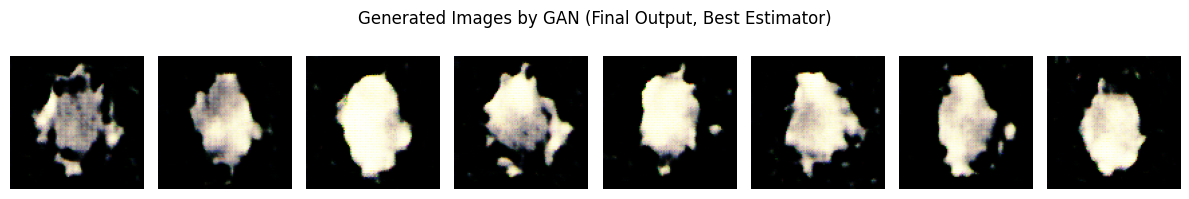

In [ ]:


EPOCHS = 20
noise_dim = 100
sample_interval = 5
PATIENCE = 5
os.makedirs("samples_tuning_mod", exist_ok=True)

# --- FID tools ---
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

def get_activations(images, model):
    images = tf.image.resize(images, (299, 299))
    images = preprocess_input(images)
    return model.predict(images, verbose=0)

def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2)).real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return float(np.real(fid))


lr_g_list = [0.0001, 0.00005]
lr_d_list = [0.0005, 0.001]

best_fid = 999999
best_params = None
best_generator = None

for lr_G in lr_g_list:
    for lr_D in lr_d_list:
        print(f"\n==== Training with LR_G={lr_G}, LR_D={lr_D} ====")
        generator_mod = build_generator_mod(noise_dim)
        discriminator_mod = build_discriminator_mod((100, 100, 3))
        optimizer_D = tf.keras.optimizers.Adam(learning_rate=lr_D)
        optimizer_G = tf.keras.optimizers.Adam(learning_rate=lr_G)
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

        @tf.function
        def train_step(real_imgs):
            batch = tf.shape(real_imgs)[0]
            noise = tf.random.normal((batch, noise_dim))
            # Generate fake images
            fake_imgs = generator_mod(noise, training=True)
            # Labels
            valid = tf.ones((batch, 1))
            fake = tf.zeros((batch, 1))
            # --- Train D ---
            with tf.GradientTape() as tape_D:
                d_real = discriminator_mod(real_imgs, training=True)
                d_fake = discriminator_mod(fake_imgs, training=True)
                d_loss_real = bce(valid, d_real)
                d_loss_fake = bce(fake, d_fake)
                d_loss = 0.5 * (d_loss_real + d_loss_fake)
            grads_D = tape_D.gradient(d_loss, discriminator_mod.trainable_weights)
            optimizer_D.apply_gradients(zip(grads_D, discriminator_mod.trainable_weights))
            # --- Train G ---
            with tf.GradientTape() as tape_G:
                noise2 = tf.random.normal((batch, noise_dim))
                gen_imgs = generator_mod(noise2, training=True)
                d_gen = discriminator_mod(gen_imgs, training=True)
                g_loss = bce(valid, d_gen)
            grads_G = tape_G.gradient(g_loss, generator_mod.trainable_weights)
            optimizer_G.apply_gradients(zip(grads_G, generator_mod.trainable_weights))
            return d_loss, g_loss

        # --- Training Loop ---
        losses_G, losses_D, fids, fid_epochs = [], [], [], []
        best_fid_val = 999999
        patience_count = 0

        for epoch in range(EPOCHS):
            d_loss_epoch, g_loss_epoch, n_batch = 0, 0, 0
            for real_imgs in dataset_gan:
                d_loss, g_loss = train_step(real_imgs)
                d_loss_epoch += float(d_loss)
                g_loss_epoch += float(g_loss)
                n_batch += 1

            loss_D = d_loss_epoch / n_batch
            loss_G = g_loss_epoch / n_batch
            losses_D.append(loss_D)
            losses_G.append(loss_G)

            if (epoch+1) % sample_interval == 0 or (epoch+1) == EPOCHS:
                noise = np.random.normal(0, 1, (100, noise_dim))
                fake_for_fid = generator_mod.predict(noise)
                fake_uint8 = ((fake_for_fid + 1) * 127.5).clip(0,255).astype(np.float32)
                real_for_fid = X_gan[np.random.choice(X_gan.shape[0], 100, replace=False)]
                real_uint8 = ((real_for_fid + 1) * 127.5).clip(0,255).astype(np.float32)
                act_real = get_activations(real_uint8, inception)
                act_fake = get_activations(fake_uint8, inception)
                fid_score = calculate_fid(act_real, act_fake)
                fids.append(fid_score)
                fid_epochs.append(epoch+1)

                if fid_score < best_fid_val:
                    best_fid_val = fid_score
                    patience_count = 0
                else:
                    patience_count += 1
                    print(f"EarlyStopping count: {patience_count}/{PATIENCE}")
                if patience_count >= PATIENCE:
                    print(f"Early stopping at epoch {epoch+1} (FID did not improve for {PATIENCE} checks)")
                    break
            else:
                fid_score = np.nan

            print(f"Epoch [{epoch+1}/{EPOCHS}]  Loss_D: {loss_D:.4f}  Loss_G: {loss_G:.4f}  FID: {fid_score if not np.isnan(fid_score) else '-'}")

            if (epoch+1) % sample_interval == 0 or (epoch+1) == EPOCHS:
                noise = np.random.normal(0, 1, (8, noise_dim))
                gen_imgs = generator_mod.predict(noise)
                gen_imgs_uint8 = ((gen_imgs + 1) * 127.5).clip(0,255).astype(np.uint8)
                plt.figure(figsize=(12, 2))
                for i in range(8):
                    plt.subplot(1, 8, i+1)
                    plt.imshow(gen_imgs_uint8[i])
                    plt.axis('off')
                plt.suptitle(f'Generated Images by GAN Mod (Epoch {epoch+1})')
                plt.savefig(f"samples_tuning_mod/sample_epoch_{epoch+1:03d}_lrG{lr_G}_lrD{lr_D}.png", bbox_inches='tight')
                plt.close()

        fid_last = fids[-1] if len(fids) > 0 else np.nan
        print(f"==> FID terakhir: {fid_last:.2f} | Loss_D: {losses_D[-1]:.4f} | Loss_G: {losses_G[-1]:.4f}")
        if fid_last < best_fid:
            best_fid = fid_last
            best_params = (lr_G, lr_D)
            best_generator = tf.keras.models.clone_model(generator_mod)
            best_generator.set_weights(generator_mod.get_weights())

        plt.plot(losses_G, label='Generator Loss')
        plt.plot(losses_D, label='Discriminator Loss')
        plt.legend()
        plt.title(f'Loss (G,D) @ LR_G={lr_G}, LR_D={lr_D}')
        plt.savefig(f'samples_tuning_mod/loss_gd_lrG{lr_G}_lrD{lr_D}.png')
        plt.close()
        plt.plot(fid_epochs, fids, marker='o')
        plt.title(f'FID @ LR_G={lr_G}, LR_D={lr_D}')
        plt.xlabel('Epoch')
        plt.ylabel('FID')
        plt.savefig(f'samples_tuning_mod/fid_lrG{lr_G}_lrD{lr_D}.png')
        plt.close()

print(f"\n\n==> Best FID: {best_fid:.2f} didapat pada params LR_G={best_params[0]}, LR_D={best_params[1]}")

n_samples = 8
z = np.random.normal(0, 1, (n_samples, noise_dim))
gen_imgs = best_generator.predict(z)
gen_imgs_uint8 = ((gen_imgs + 1.0) * 127.5).clip(0, 255).astype(np.uint8)
plt.figure(figsize=(12, 2))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.imshow(gen_imgs_uint8[i])
    plt.axis('off')
plt.suptitle('Generated Images by GAN (Final Output, Best Estimator)')
plt.tight_layout()
plt.show()


## Perbandingan Hasil GAN: Tuning + Modifikasi Model (Bawah) vs Modifikasi Saja (Aats)

### 1. Nilai FID (Fréchet Inception Distance)
- **FID Tuning :** Nilai FID terbaik ≈ **364**  
- **FID Modifikasi Saja :** Nilai FID terbaik ≈ **340–380**  
- **Interpretasi:** FID yang **lebih kecil** menandakan distribusi gambar hasil generate lebih mirip dengan data asli. Dalam eksperimen ini, model **modifikasi saja memberikan FID yang sedikit **lebih baik** daripada model tuning (kiri).

### 2. Kualitas Gambar Hasil Generate
- **Tuning :**
    - Gambar pistachio yang dihasilkan sudah mulai tampak bentuknya.
    - Namun, sebagian besar gambar masih terlihat blur (kabur) dan detail tekstur kurang jelas.
    - Variasi bentuk belum begitu tinggi, dan beberapa gambar terlihat “tumpul”.
- **Modifikasi Saja :**
    - Bentuk kacang pistachio pada gambar hasil generate sedikit lebih stabil dan tepi lebih tegas.
    - Walaupun masih blur, beberapa output lebih mudah dikenali secara visual.
    - Perbedaan secara visual tipis, namun model modifikasi terlihat lebih konsisten.

### 3. Insight
- **Tuning hyperparameter** (LR_G, LR_D) pada kasus ini **belum berhasil meningkatkan kualitas**, bahkan sedikit menurunkan performa FID.
- **Model modifikasi saja** (tanpa tuning agresif) justru menunjukkan kestabilan dan hasil yang lebih baik secara metrik FID.
- Kemungkinan penyebab tuning tidak optimal: dataset terbatas, augmentasi kurang representatif, atau kombinasi learning rate yang kurang pas pada GAN.
- Penurunan jumlah epochs dari 50 menjadi 20 juga memberikan dampak pada hasil pelatihan GAN. Model yang hanya dilatih selama 20 epoch memiliki waktu belajar yang lebih singkat sehingga sering kali belum mencapai konvergensi optimal. Hal ini dapat menyebabkan kualitas gambar yang dihasilkan belum maksimal dan nilai FID yang didapatkan cenderung lebih tinggi. Oleh karena itu, selain tuning pada hyperparameter seperti learning rate, pemilihan jumlah epoch yang cukup juga sangat penting untuk memberikan kesempatan model belajar dengan baik terhadap distribusi data aslinya.

### 4. **Kesimpulan**
- **Model modifikasi tanpa tuning** memberikan hasil **yang lebih baik** dari segi FID dan juga cukup kompetitif dari sisi visual.
- **Tuning** pada hyperparameter GAN tidak selalu menjamin perbaikan kualitas, terutama jika kombinasi parameter tidak optimal.
- **Saran:** Ke depannya, fokus tuning pada arsitektur model dan data augmentation bisa lebih bermanfaat dibanding sekadar mengubah learning rate.





# Apa persamaan antara GAN dan mahasiswa?"
Sama-sama takut di-judge…
(Apalagi pas ujian, kayak Discriminator ngasih nilai ke Generator!) 😅